# BASIC #

In [56]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from stock_trading_environment import StockTradingEnvironment, Positions

import dqn
from dqn import ReplayMemory, DQN

import plot_dqn as plot

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [2]:
#function for saving trained models in a folder
def uniquify(path):
    filename, extension = os.path.splitext(path)
    counter = 1

    while os.path.exists(path):
        path = filename + " (" + str(counter) + ")" + extension
        counter += 1

    return path

In [3]:
#autoreload modified modules
%load_ext autoreload
%autoreload 2

# DATA PIPELINE #

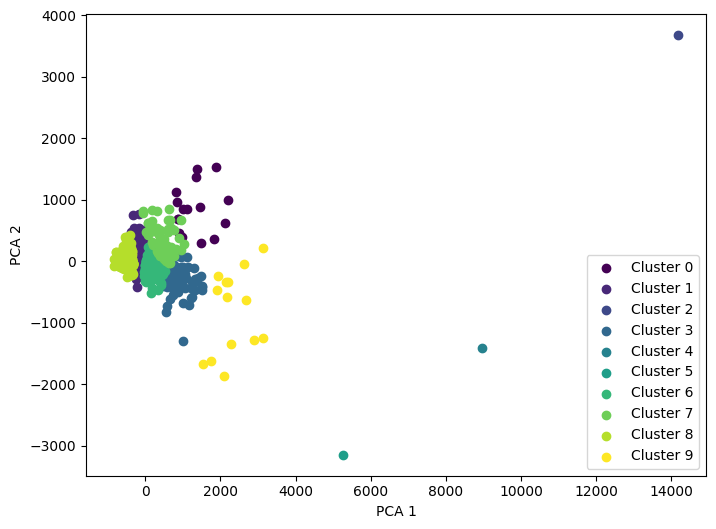

In [4]:
'''
Data pipeline:
    - Read filtered stocks closing prices as CSV/in SQL
    - Find clusters with kmeans and PCA
    - Filter out some outlier clusters; key clusters # as a dict
    - Find cointegration of each key cluster and plot heatmap
'''
import data_pipeline as pipeline
import config

pgConnStr = config.pgDictToConn(config.pgSecrets)
random_state = 42

n_clusters = 10
dailyDF = pipeline.getDailyPrices(pipeline.getDailyPricesTickersLst(pgConnStr), pgConnStr)
clusters = pipeline.findStockClusters(dailyDF, n_clusters)
good_clusters_dict = pipeline.findStocksinClusters(clusters, n_clusters)
pipeline.plotStockClusters(clusters)

In [5]:
#just to check how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 16 stocks
cluster 1: 342 stocks
cluster 3: 74 stocks
cluster 6: 234 stocks
cluster 7: 72 stocks
cluster 8: 337 stocks
cluster 9: 14 stocks


[('RM', 'FBMS'), ('SCVL', 'GRC'), ('GRC', 'ALCO'), ('GRC', 'EVA'), ('GRC', 'LZB'), ('GRC', 'DWAC'), ('GCBC', 'FBMS'), ('GCBC', 'BBU'), ('GCBC', 'FMBH'), ('GCBC', 'HSII'), ('ALCO', 'EVA'), ('ALCO', 'LZB'), ('ALCO', 'FMBH'), ('FRG', 'SHYF'), ('FRG', 'HZO'), ('FRG', 'RVLV'), ('FRG', 'DOMO'), ('LZB', 'DWAC'), ('GOOS', 'HSII'), ('BBU', 'HSII'), ('BALY', 'VCEL')]


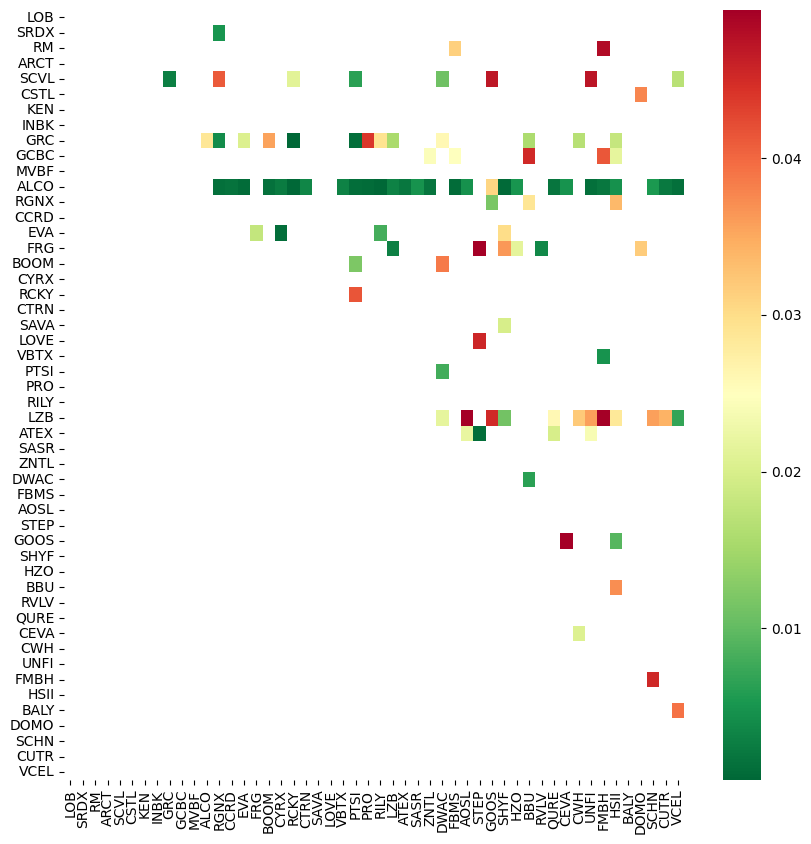

In [7]:
#split train/test data by time: 70/30#
#manually choose cluster of a reasonable size (80-100 stocks) AND REASONABLY DISPERSED for training model
dailyDF_train = dailyDF[good_clusters_dict[7]]

train_startdate = dailyDF_train.index[0]
train_enddate = train_startdate + pd.DateOffset(years=5)
trainpairs, trainpval, traindf = pipeline.cointHeatmap(dailyDF_train.loc[train_startdate:train_enddate].dropna(axis=1, how='all'), 
                                                       random_state)

In [60]:
#create trainenvs
window_size = 60
#trade_period = 5
transaction_cost = 0.05

trainenvs = []
for trainpair in trainpairs:
    traindata = traindf[list(trainpair)].dropna()
    if traindata.shape[0] > 450:
        trainenvs.append(StockTradingEnvironment(traindata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()


In [61]:
print(f'The no. of trainpairs and trainevns are respectively {len(trainpairs)} and {len(trainenvs)}.')

The no. of trainpairs and trainevns are respectively 21 and 17.


[('ARCT', 'TPB'), ('ARCT', 'CSTL'), ('ARCT', 'TASK'), ('ARCT', 'GOOS'), ('ARCT', 'BALY'), ('ARCT', 'DOMO'), ('TPB', 'VCEL'), ('TPB', 'BALY'), ('CSTL', 'BALY'), ('SRDX', 'CWH'), ('RM', 'ATEX'), ('LOVE', 'VCEL'), ('RILY', 'SASR'), ('RILY', 'ATEX'), ('RILY', 'FMBH'), ('RILY', 'HZO'), ('RILY', 'SCHN'), ('SASR', 'ATEX'), ('ATEX', 'HSII'), ('ATEX', 'SCHN'), ('SCVL', 'VCEL'), ('VCEL', 'RCKY'), ('VCEL', 'PRO'), ('VCEL', 'QURE'), ('VCEL', 'CWH'), ('INBK', 'DWAC'), ('SAVA', 'GOOS'), ('SAVA', 'CWH'), ('PRO', 'LZB'), ('FRG', 'GRC'), ('FRG', 'DWAC'), ('ZNTL', 'BBU'), ('DWAC', 'AOSL'), ('LZB', 'CEVA'), ('LZB', 'XNCR'), ('GOOS', 'BBU'), ('HSII', 'SCHN')]


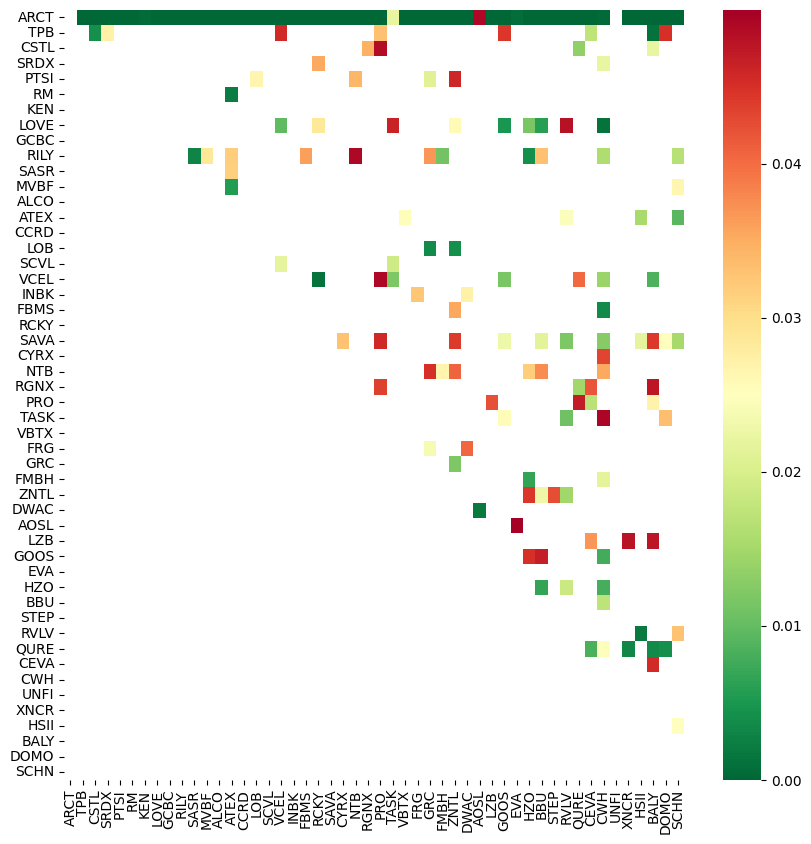

In [59]:
#val set heatmap
valpairs, valpval, valdf = pipeline.cointHeatmap(dailyDF_train.loc[train_enddate:].dropna(axis=1, how='all'), 
                                                 random_state=random_state)

In [62]:
#create valenvs
valenvs = []
for valpair in valpairs:
    valdata = valdf[list(valpair)].dropna()
    if valdata.shape[0] > 250:
        valenvs.append(StockTradingEnvironment(valdata.copy(), window_size, transaction_cost))   #instantiate an env; automatatically run trade()

In [63]:
print(f'The no. of validation pairs and validation evns are respectively {len(valpairs)} and {len(valenvs)}.')

The no. of validation pairs and validation evns are respectively 37 and 37.


# DEEP Q-NETWORK #

In [65]:
BATCH_SIZE = 256   #increased fom 128
GAMMA = 0.9          #decreased from 0.999
EPS_START = 0.9
EPS_END = 0.02   #decreased from 0.05
EPS_DECAY = 2000  #increased from 200
TARGET_UPDATE = 5

# Get number of actions from gym action space
n_actions = 2   #only trade or not_trade

policy_net = DQN(window_size + 2, n_actions, device).to(device)   #input size depends on length of status/obs; here window_size=60=past 60 zscores
target_net = DQN(window_size + 2, n_actions, device).to(device)
target_net.load_state_dict(policy_net.state_dict())   #target_net loads state_dict of policy_net
target_net.eval()   #set target_net to evaluate mode

optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-6)   #from torch.optim; RMSprop = optimizer like SGD or Adam; lr decreased from 1e-4
memory = ReplayMemory(127000)   #increased from 10000

In [66]:
#training agent
num_episodes = 300
best_rewards = 0
steps_done = 0

#empty dicts to collect train/test rewards/returns
train_reward_dict = {}
train_return_dict = {}
val_reward_dict = {}
val_return_dict = {}


for i_episode in range(num_episodes):
    policy_net.train()   #sets mode to training mode
    train_rewards = []
    train_returns = []

    #initialize train_reward_dict and train_return_dict for this
    train_reward_dict[i_episode] = []
    train_return_dict[i_episode] = []
    val_reward_dict[i_episode] = []
    val_return_dict[i_episode] = []

    #initialize nn_counter for this episode
    nn_counter = 0
    
    for trainenv in trainenvs:
    #for env in [testinst]:
        # Initialize the environment and state
        obs = trainenv.reset()   #reset() will get (zscore, [self._position.value, self.pvalue])
        state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
        
        for t in count():   #keep looping until done -> break
            # Select and perform an action and return whether this action is returned by policy_network
            action, nn_count = policy_net.select_action(state, EPS_START, EPS_END, EPS_DECAY, steps_done, policy_net, n_actions)   #epsilon-greedy: exploit or explore; state is this state
            #obs, reward, done, info = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            obs, step_reward, done, info, step_return = trainenv.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            #reward is step_reward for this step
            #obs, reward, done = env.step(Positions(action.item()))   #obs is after env.step, so new observation; each step = 5 trade periods
            
            #append reward and return of this episode in the list
            train_reward_dict[i_episode].append(step_reward)
            train_return_dict[i_episode].append(step_return)
            
            step_reward = torch.tensor([step_reward], dtype=torch.float, device=device)
            step_return = torch.tensor([step_return], dtype=torch.float, device=device)

            # Observe new state
            if not done:
                next_state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            else:
                next_state = None

            # Store the transition in memory
            #current state status, action, next state status, reward
            #each state means 60 past zscores + current action + pvalue
            #each memory pushes 62 + 62 + 3 = 127 
            memory.push(state, action, next_state, step_reward)

            # Move to the next state
            state = next_state

            #tick steps_done to trigger epsilon-greedy
            steps_done += 1
            nn_counter += nn_count

            #new
            #train_rewards.append(reward)

            # Perform one step of the optimization (on the policy network)
            policy_net.optimize_model(memory, BATCH_SIZE, policy_net, target_net, GAMMA, optimizer)   #optimize policy network with back propagation
            if done:
                train_rewards.append(info['total_reward'])
                train_returns.append(info['total_return'])
                break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:   #update target network every 5 episodes
        target_net.load_state_dict(policy_net.state_dict())   #update target network with policy network parameters
    
    # Validation
    policy_net.eval()   #validate, so set policy network at eval mode
    val_rewards = []
    val_returns = []
    with torch.no_grad():
        for valenv in valenvs:
            
            obs = valenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)   #action returned by policy_net given state
                obs, step_reward, done, info, step_return = valenv.step(Positions(action.item()))   #take a step based on action returned by nn
                #obs, reward, done = env.step(Positions(action.item()))   #take a step based on action returned by nn
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)

                #new
                #test_rewards.append(reward)

                #append reward and return of this episode in the list
                val_reward_dict[i_episode].append(step_reward)
                val_return_dict[i_episode].append(step_return)

                if done:
                    val_rewards.append(info['total_reward'])
                    val_returns.append(info['total_return'])
                    break

    avg_rewards = np.mean(val_rewards)
    if (avg_rewards > best_rewards) and (i_episode != 0):   #disregarding the 1st model because the 1st model often has highest score and it's useless to save
        best_rewards = avg_rewards
        torch.save(policy_net.state_dict(), uniquify('./models/model.pth'))   #save trained model (policy_net) as a state_dict for future use

    print('epoch [{}/{}], train rewards:{:.4f}, returns:{:.4f}, val rewards:{:.4f}, returns:{:.4f}, policy_nn_actions:{}, training steps:{}'.format
          (i_episode + 1, num_episodes, np.mean(train_rewards), np.mean(train_returns), np.mean(val_rewards),
           np.mean(val_returns), nn_counter, len(train_reward_dict[i_episode])))

print('Complete')

epoch [1/300], train rewards:-34.9486, returns:-18.1512, val rewards:0.0000, returns:0.0000, policy_nn_actions:24071, training steps:26357
epoch [2/300], train rewards:-26.8348, returns:-13.2345, val rewards:0.0000, returns:0.0000, policy_nn_actions:25827, training steps:26357
epoch [3/300], train rewards:-16.3721, returns:-7.9989, val rewards:0.0000, returns:0.0000, policy_nn_actions:25849, training steps:26357
epoch [4/300], train rewards:-15.2085, returns:-7.4015, val rewards:-0.3094, returns:-0.1210, policy_nn_actions:25791, training steps:26357
epoch [5/300], train rewards:-13.6757, returns:-5.7691, val rewards:0.9604, returns:1.8637, policy_nn_actions:25822, training steps:26357
epoch [6/300], train rewards:-12.3613, returns:-6.0192, val rewards:1.6288, returns:2.2393, policy_nn_actions:25765, training steps:26357
epoch [7/300], train rewards:-11.8656, returns:-4.4321, val rewards:0.6839, returns:1.5111, policy_nn_actions:25829, training steps:26357
epoch [8/300], train rewards:-

KeyboardInterrupt: 

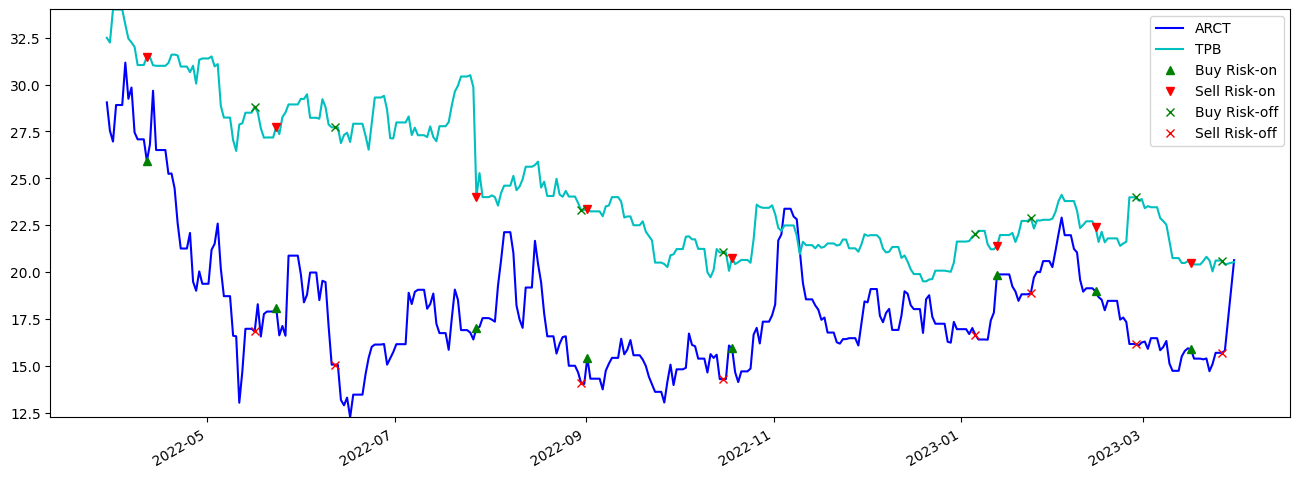

Total reward for this pair: -26.00641982870527
Total return for this pair: -25.209826068572422


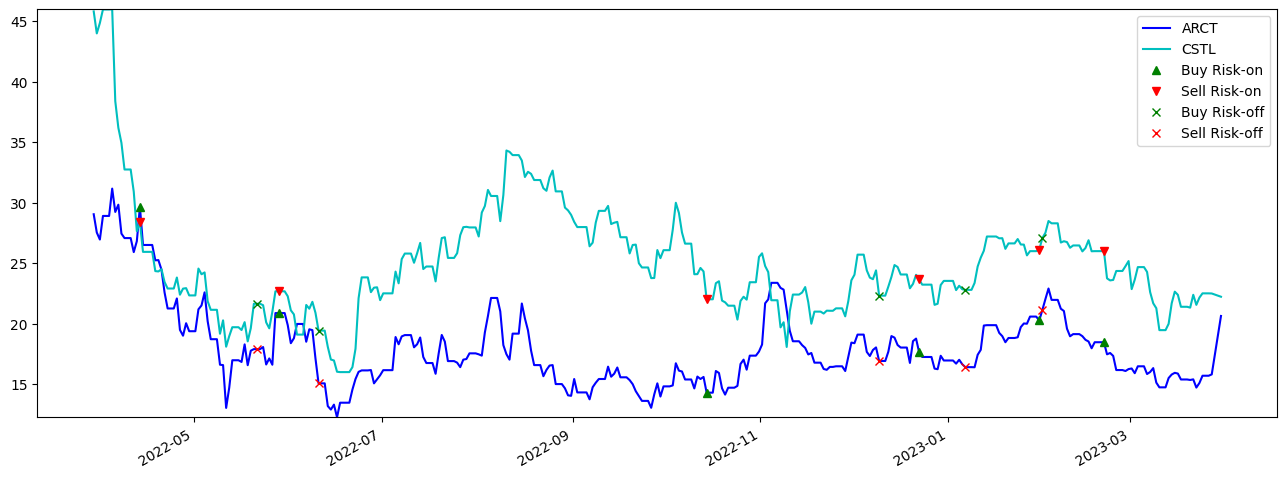

Total reward for this pair: -15.880736537424857
Total return for this pair: -15.050400271270458


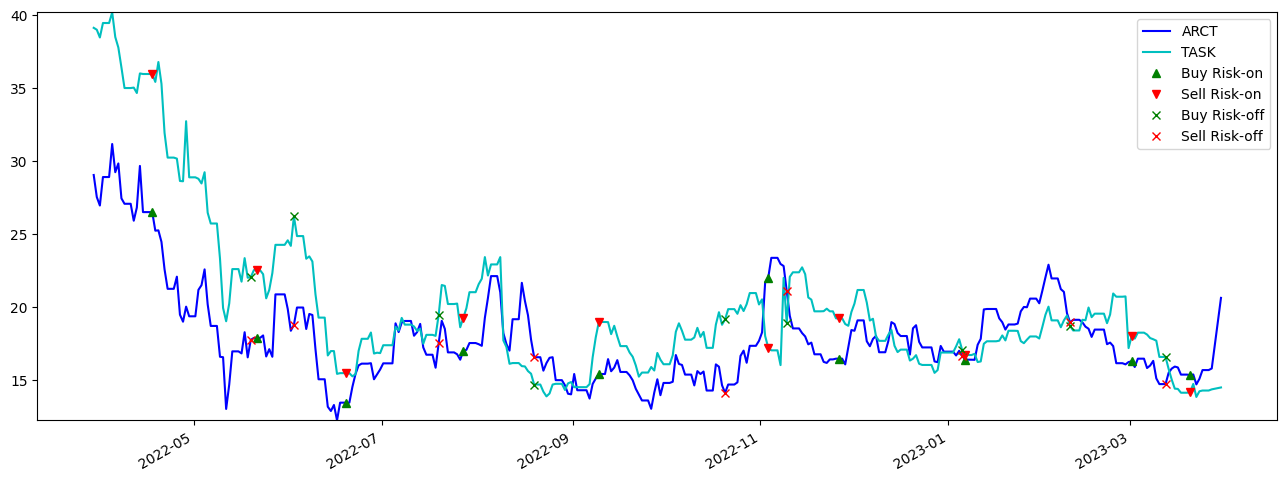

Total reward for this pair: -1.7439608018422321
Total return for this pair: -1.5244183914232712


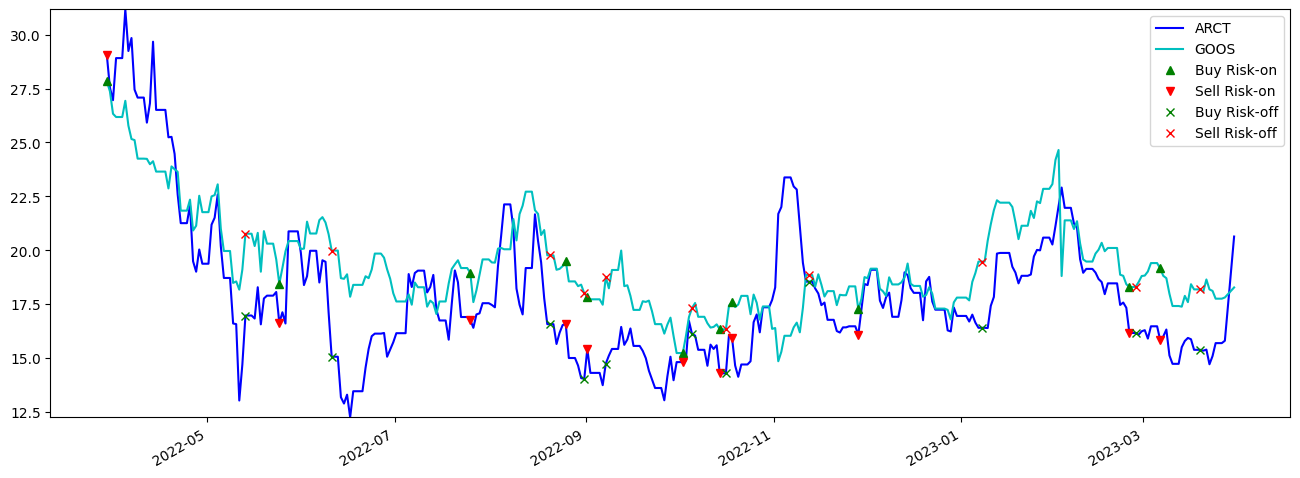

Total reward for this pair: 8.969343841222479
Total return for this pair: 9.265454359768873


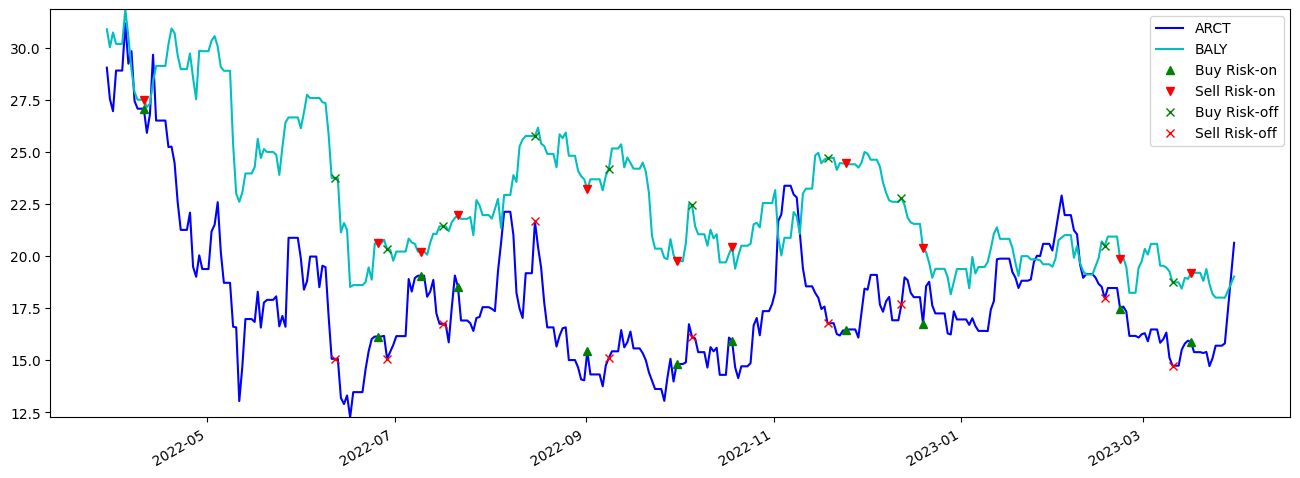

Total reward for this pair: -29.496973797655343
Total return for this pair: -29.17178750552472


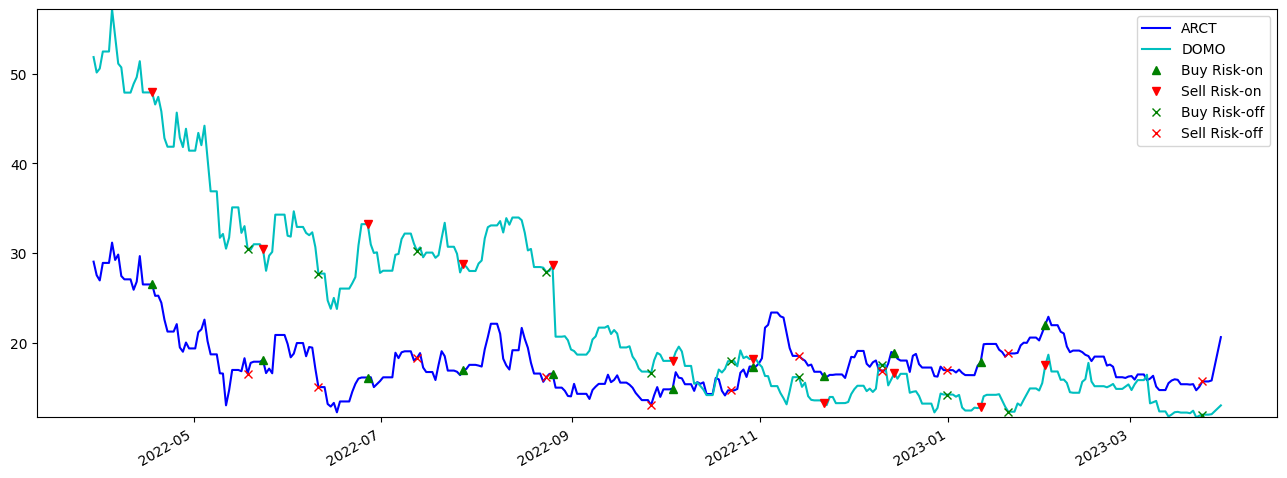

Total reward for this pair: -12.77885409256801
Total return for this pair: -12.593543135012936


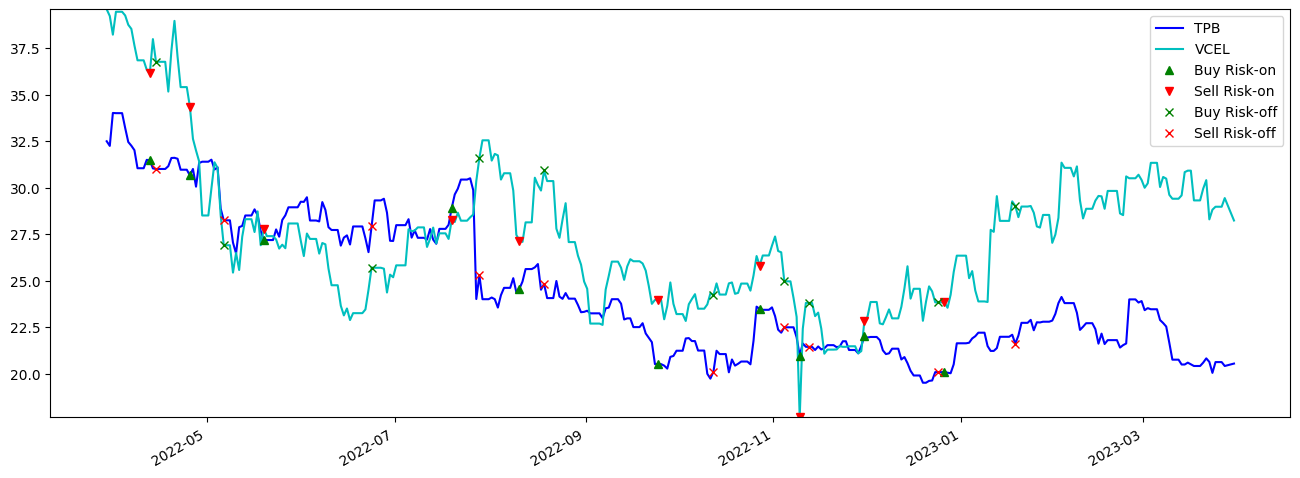

Total reward for this pair: -24.32516625094725
Total return for this pair: -23.362806870312745


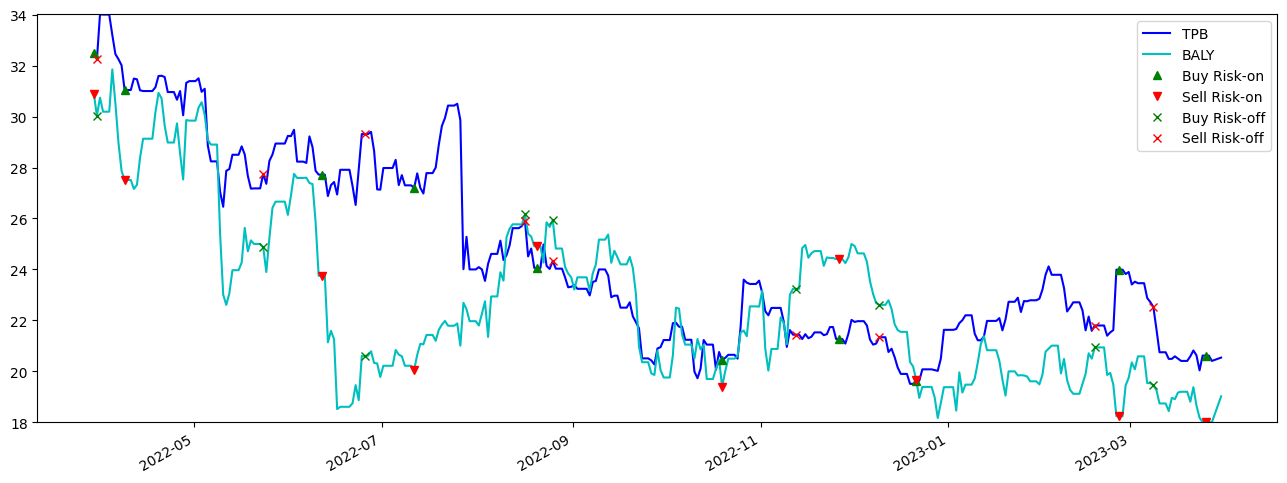

Total reward for this pair: -12.677923293172974
Total return for this pair: -12.164180925838917


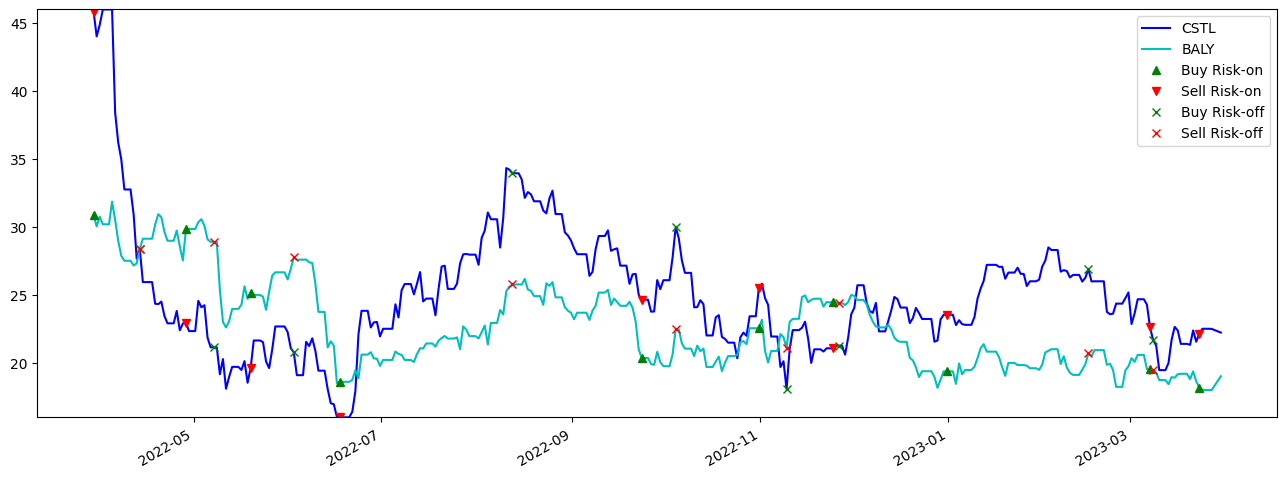

Total reward for this pair: 48.59214381815586
Total return for this pair: 48.96756881012037


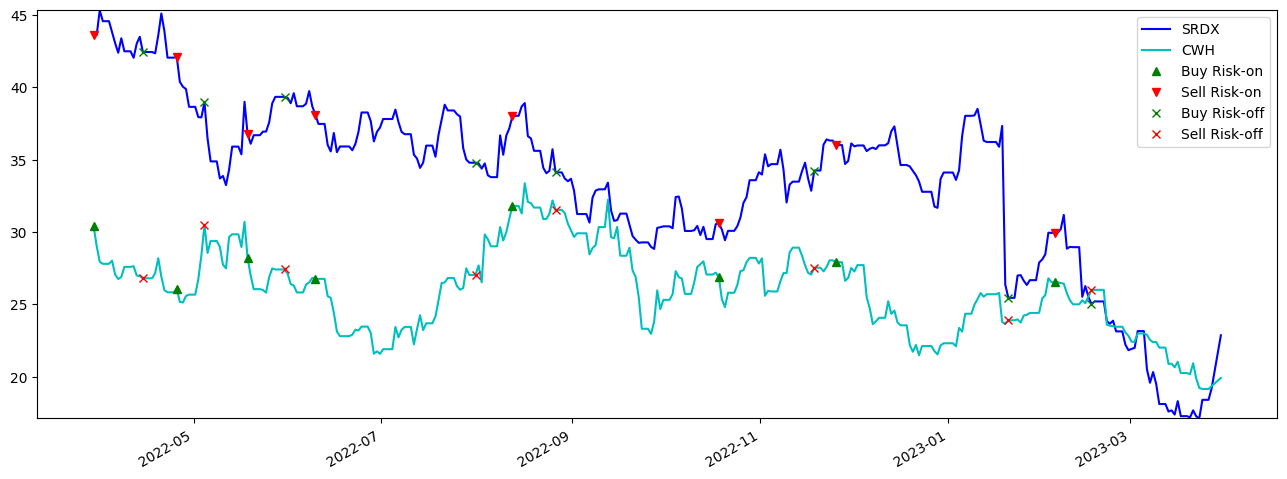

Total reward for this pair: 18.10668353177893
Total return for this pair: 18.10668353177893


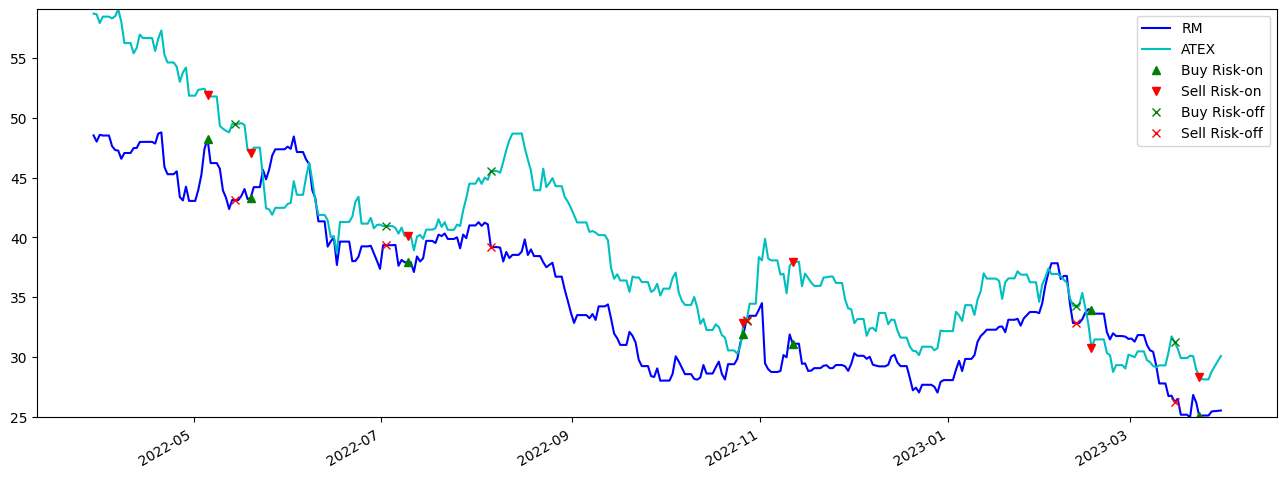

Total reward for this pair: -10.254646749744419
Total return for this pair: -9.14980174720963


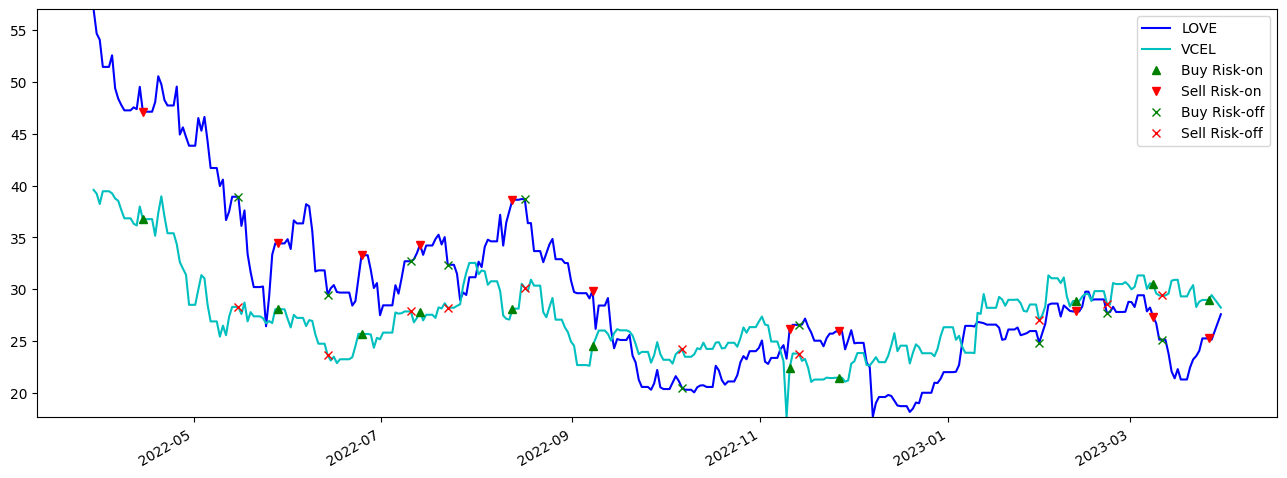

Total reward for this pair: 37.39433478415021
Total return for this pair: 38.068679777465306


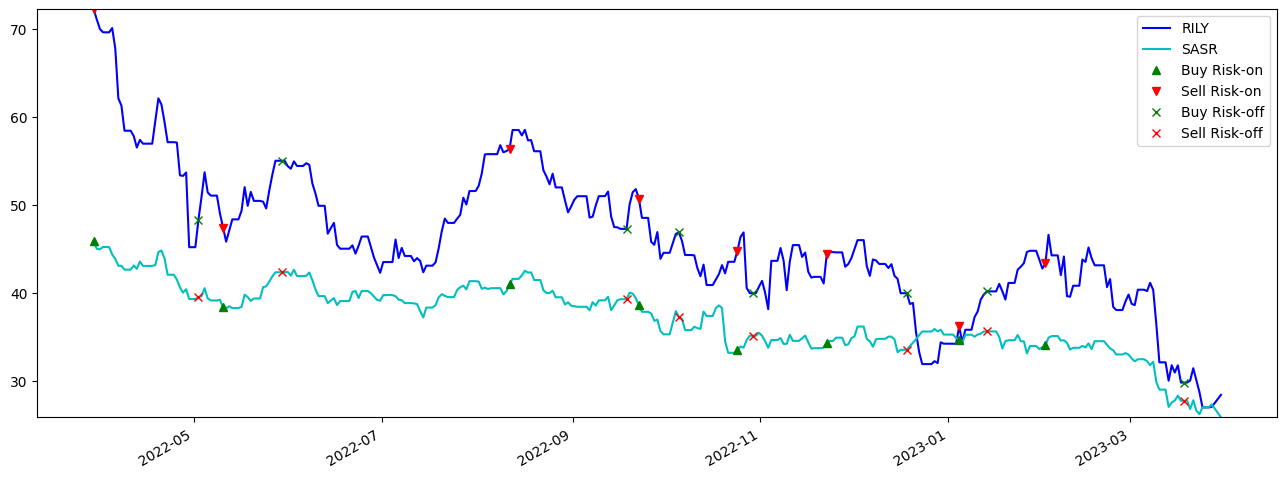

Total reward for this pair: 30.14637313731089
Total return for this pair: 30.916523769552185


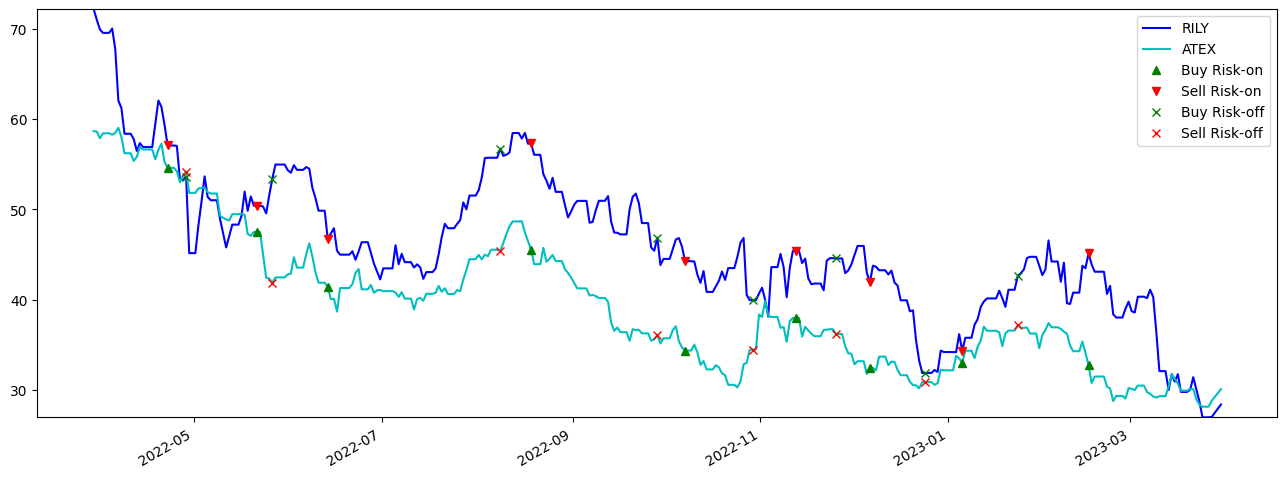

Total reward for this pair: 16.769475133150692
Total return for this pair: 18.266636686448912


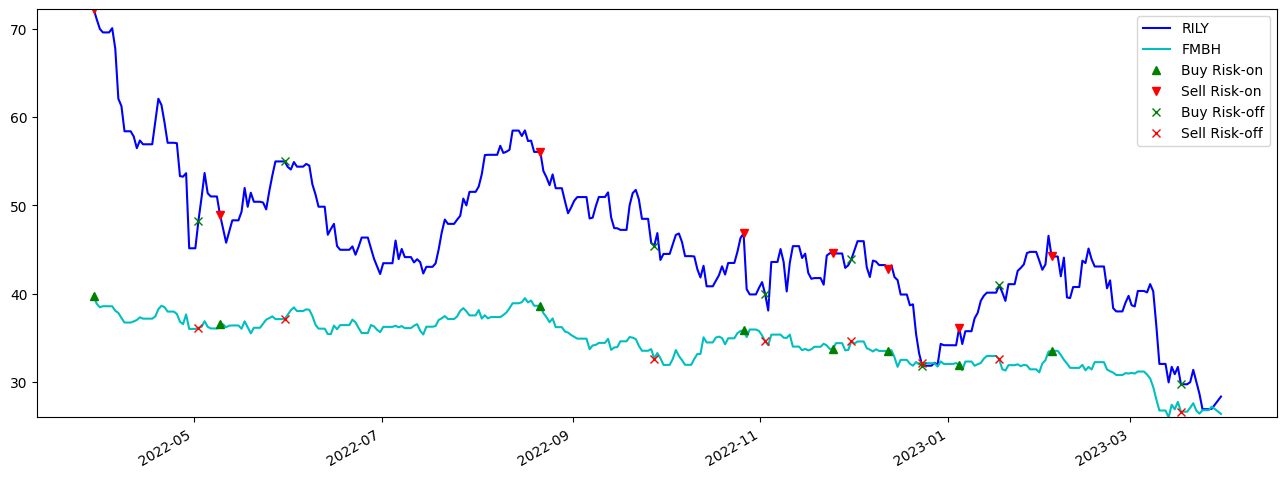

Total reward for this pair: 26.54648570249472
Total return for this pair: 26.679524870324823


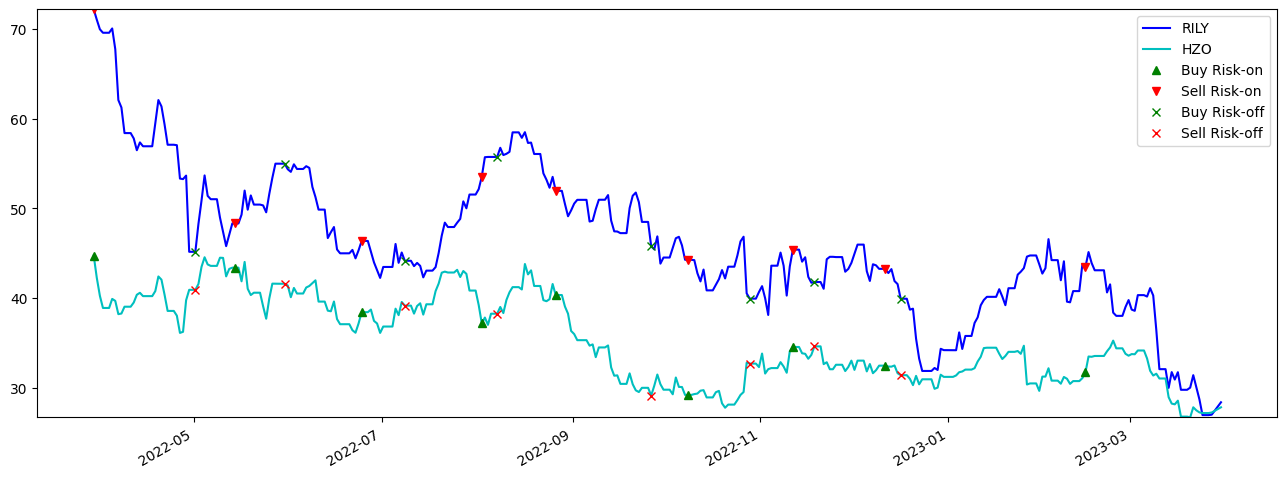

Total reward for this pair: 30.16897119067717
Total return for this pair: 30.59638892153006


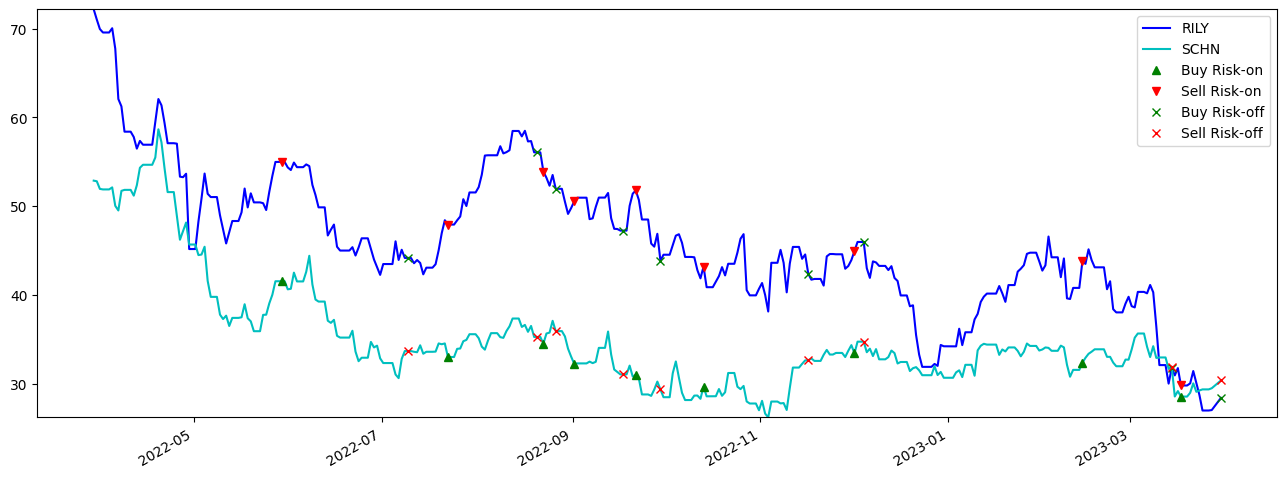

Total reward for this pair: 36.16935692204813
Total return for this pair: 37.591507929427465


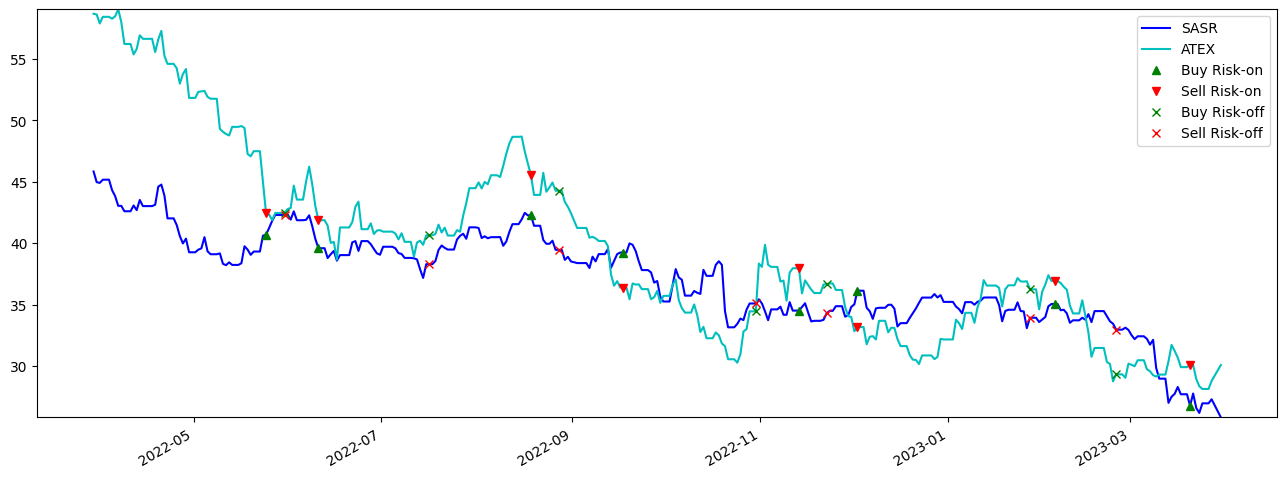

Total reward for this pair: -18.33924799522295
Total return for this pair: -18.105400527172748


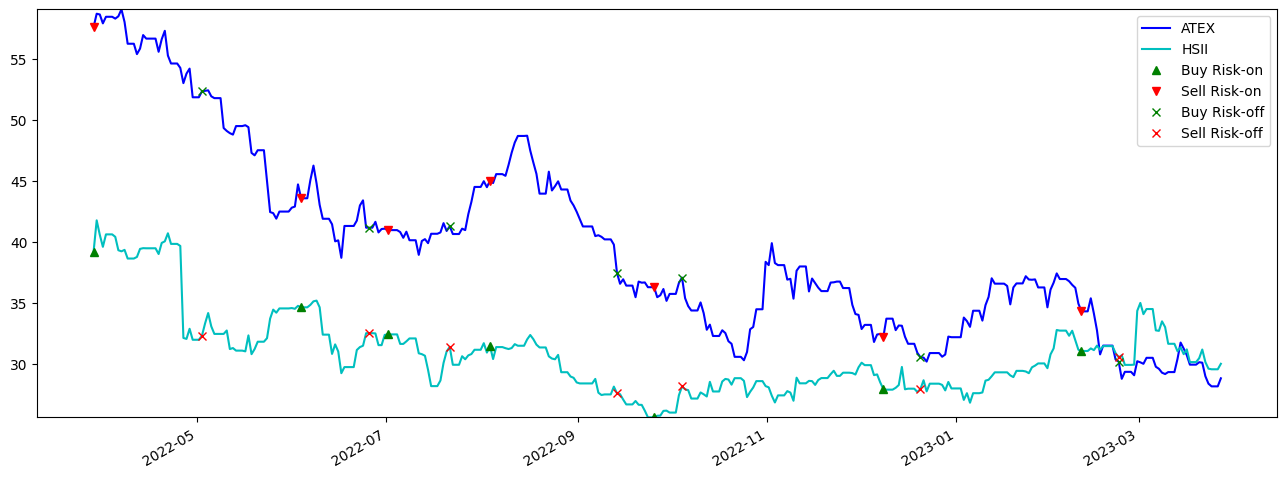

Total reward for this pair: 19.891591820425994
Total return for this pair: 19.942237003296764


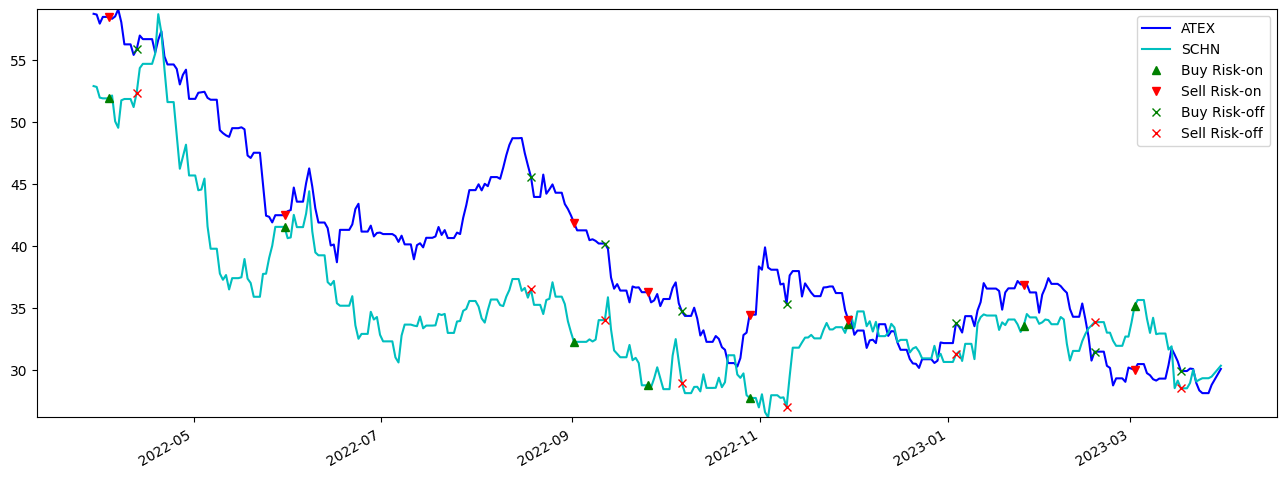

Total reward for this pair: 19.42131353384215
Total return for this pair: 20.04322388575634


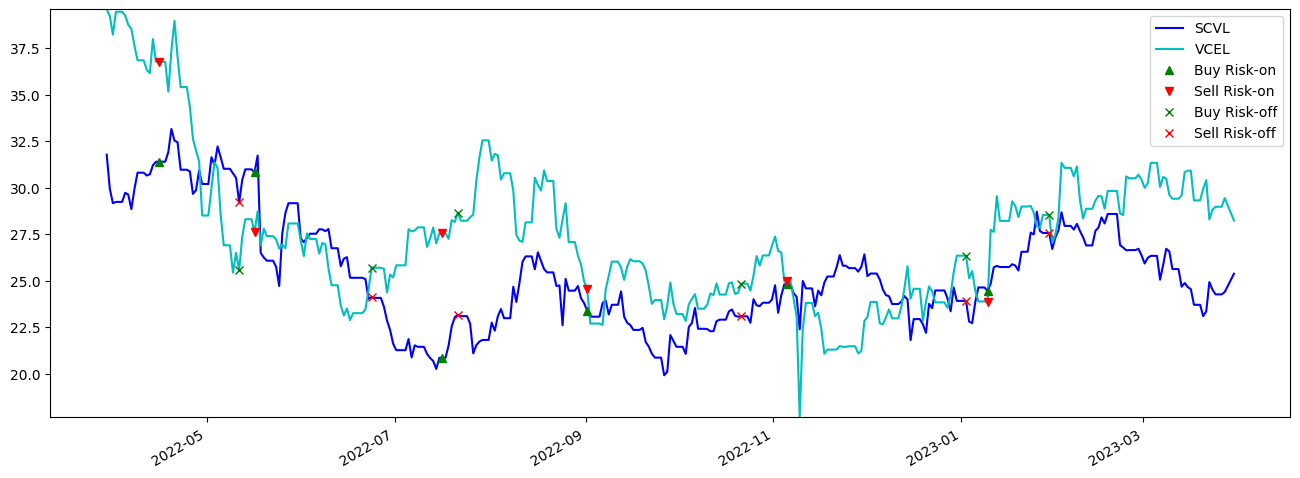

Total reward for this pair: 12.486388073949477
Total return for this pair: 12.995119837276135


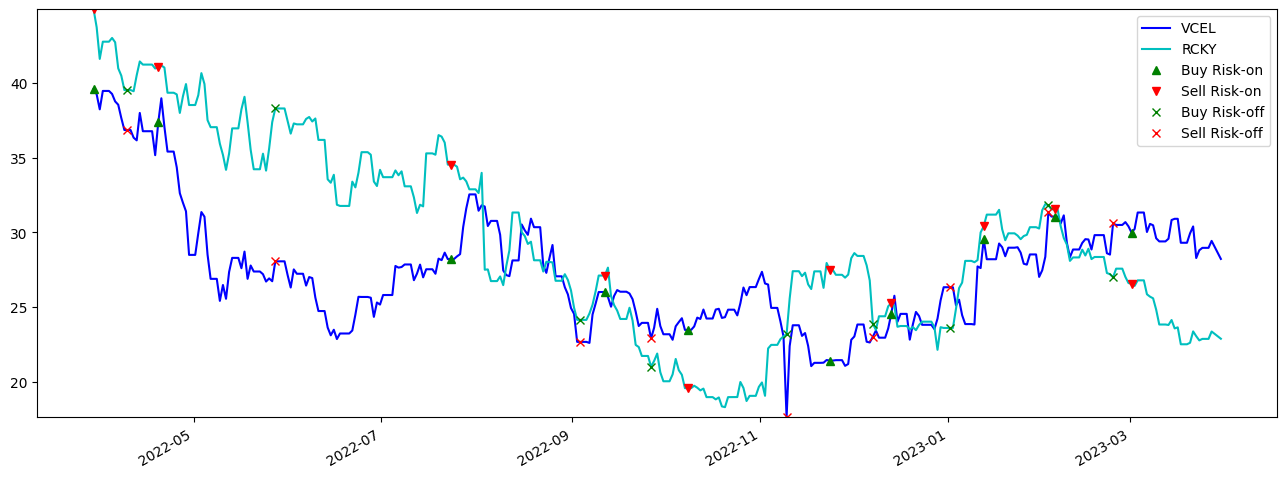

Total reward for this pair: -25.57732042405827
Total return for this pair: -25.185627630507653


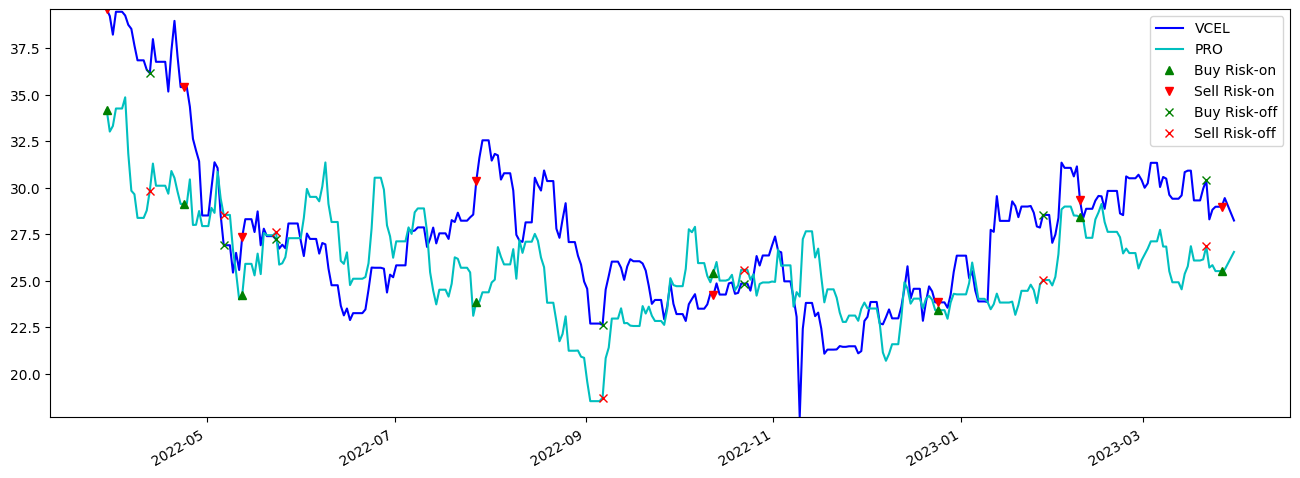

Total reward for this pair: 6.370208330851517
Total return for this pair: 6.548851407634019


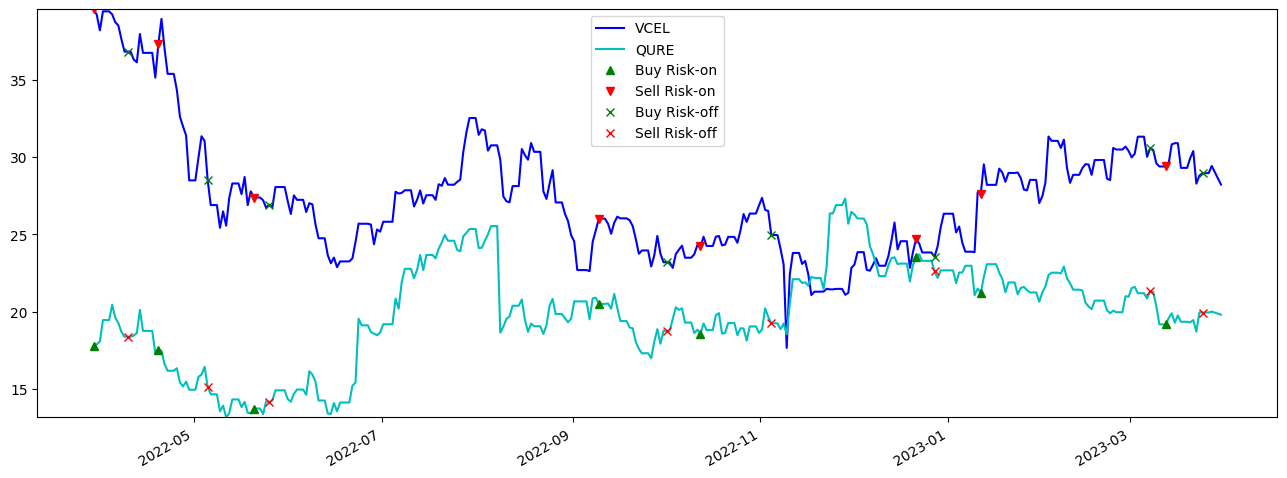

Total reward for this pair: 1.1953646109614338
Total return for this pair: 2.3870199617609815


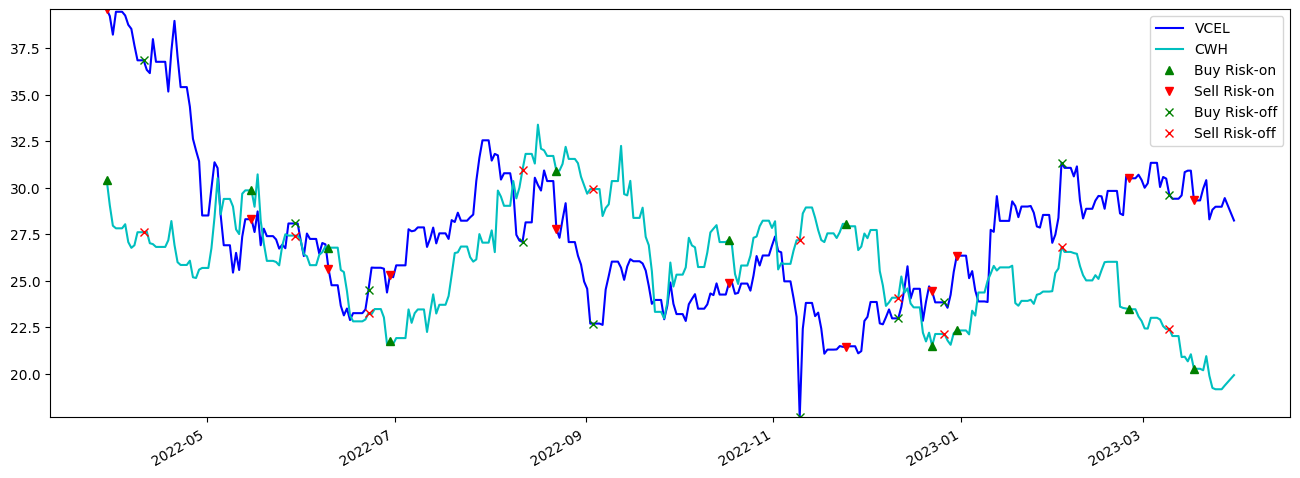

Total reward for this pair: 30.531619372078485
Total return for this pair: 31.191611967319698


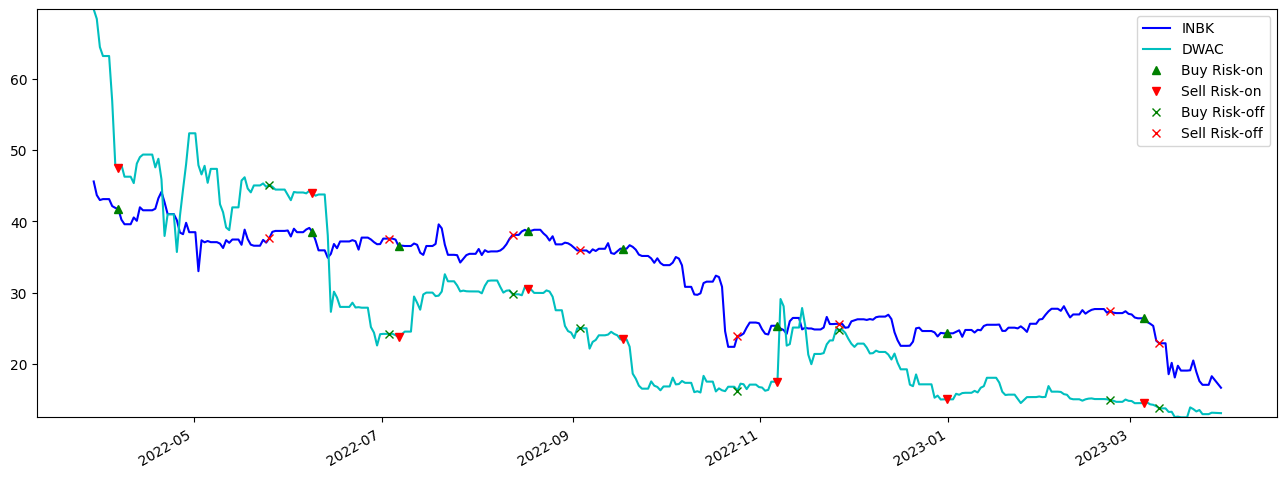

Total reward for this pair: -18.035515008090876
Total return for this pair: -16.839219113114094


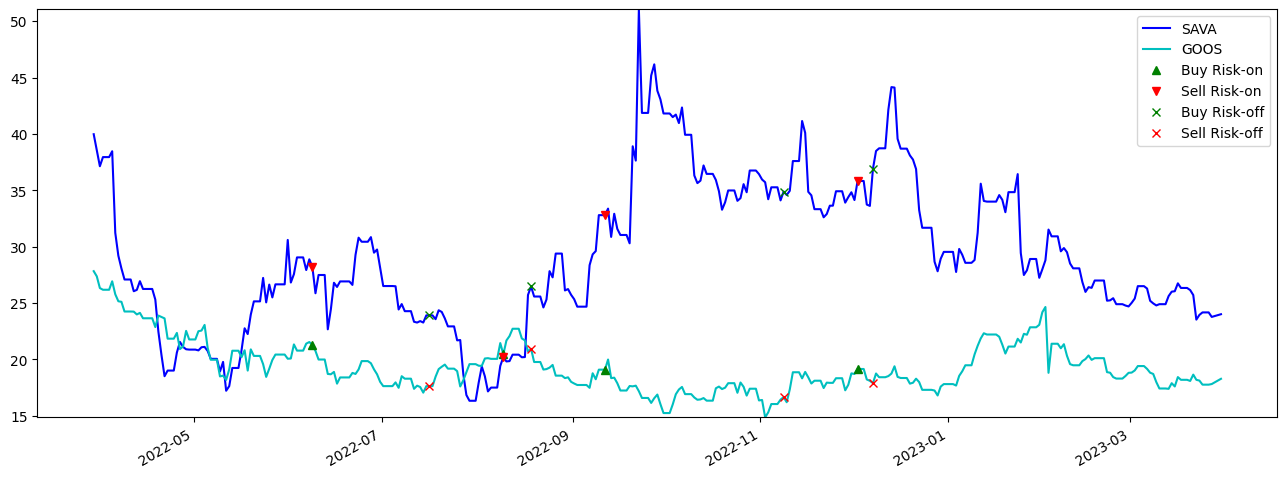

Total reward for this pair: 91.86789935043241
Total return for this pair: 94.36931695988207


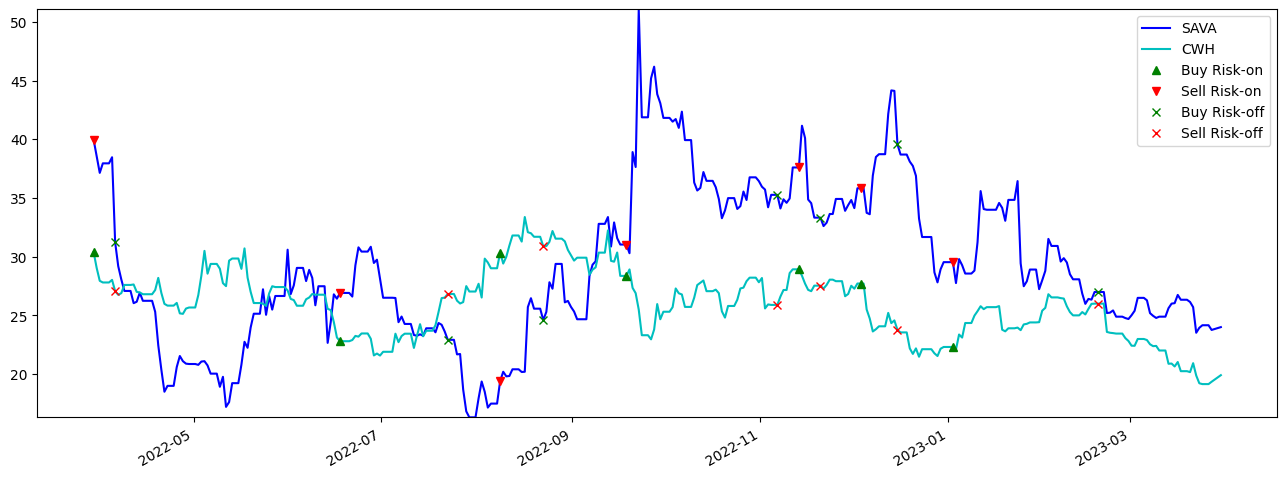

Total reward for this pair: 54.46186298491311
Total return for this pair: 54.56023601863585


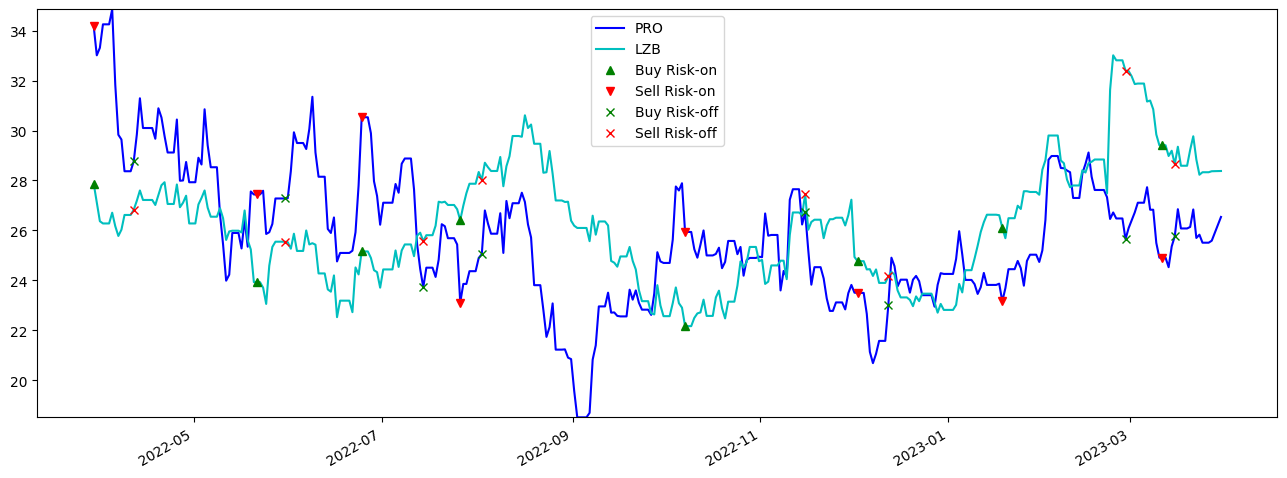

Total reward for this pair: 26.777777347285912
Total return for this pair: 26.863023536448576


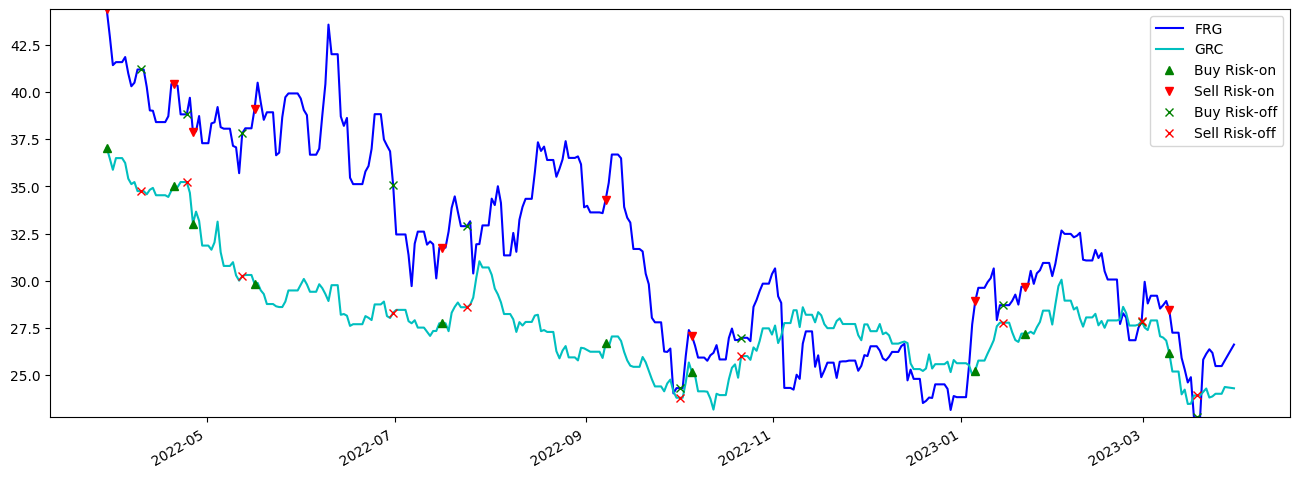

Total reward for this pair: 28.42050767305476
Total return for this pair: 29.513361504014174


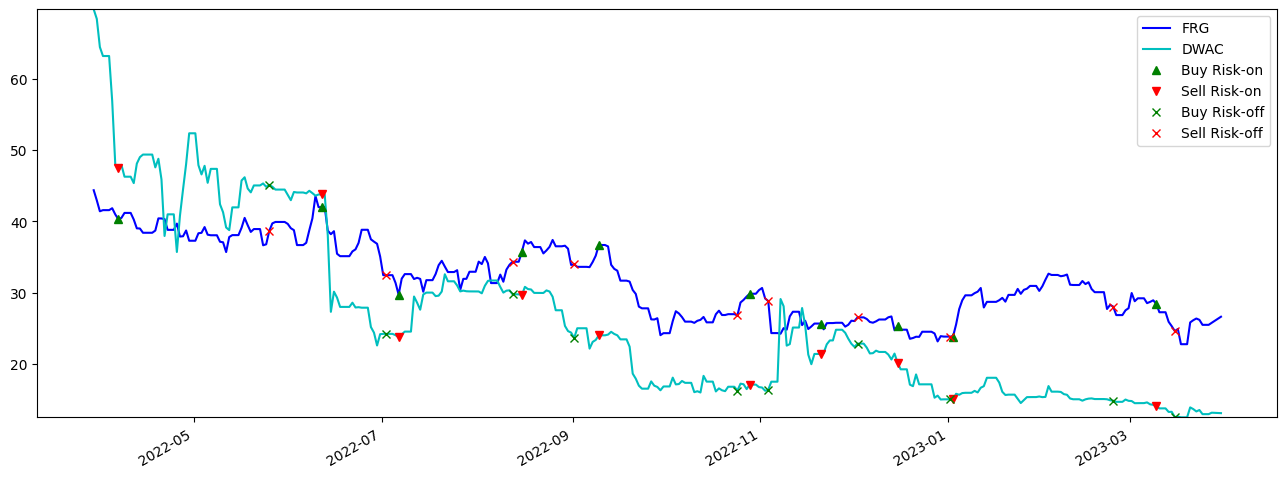

Total reward for this pair: -53.892962072862915
Total return for this pair: -53.11352210851957


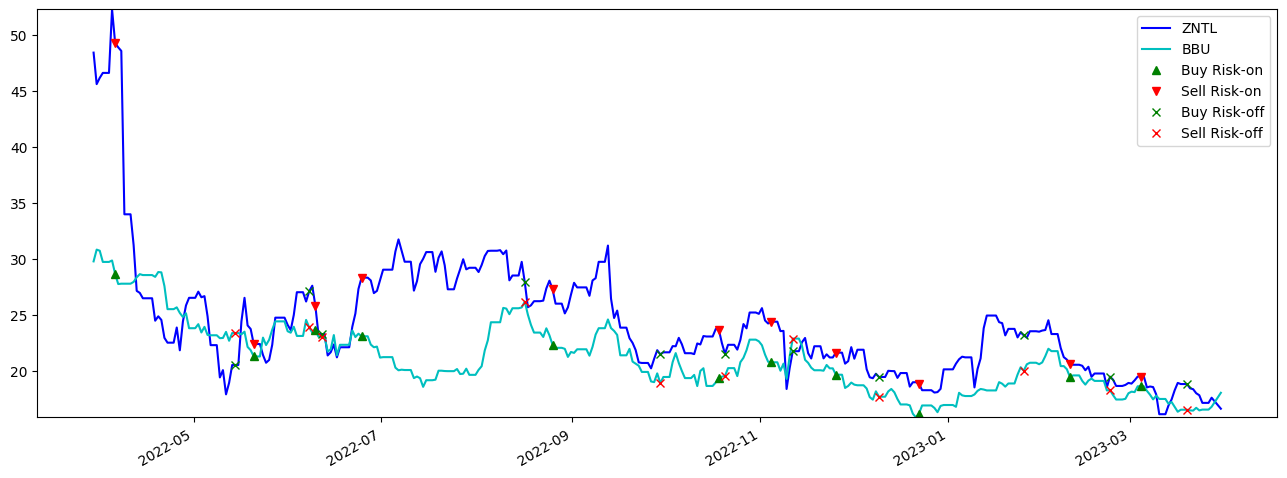

Total reward for this pair: 28.017681095016293
Total return for this pair: 28.285094177427755


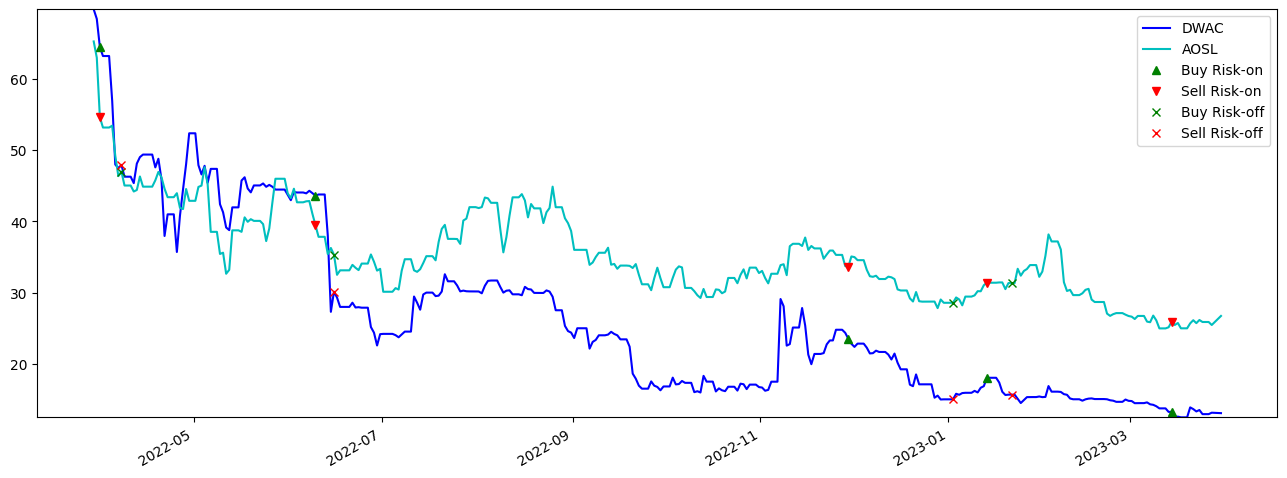

Total reward for this pair: -31.49791211812201
Total return for this pair: -31.39189540434793


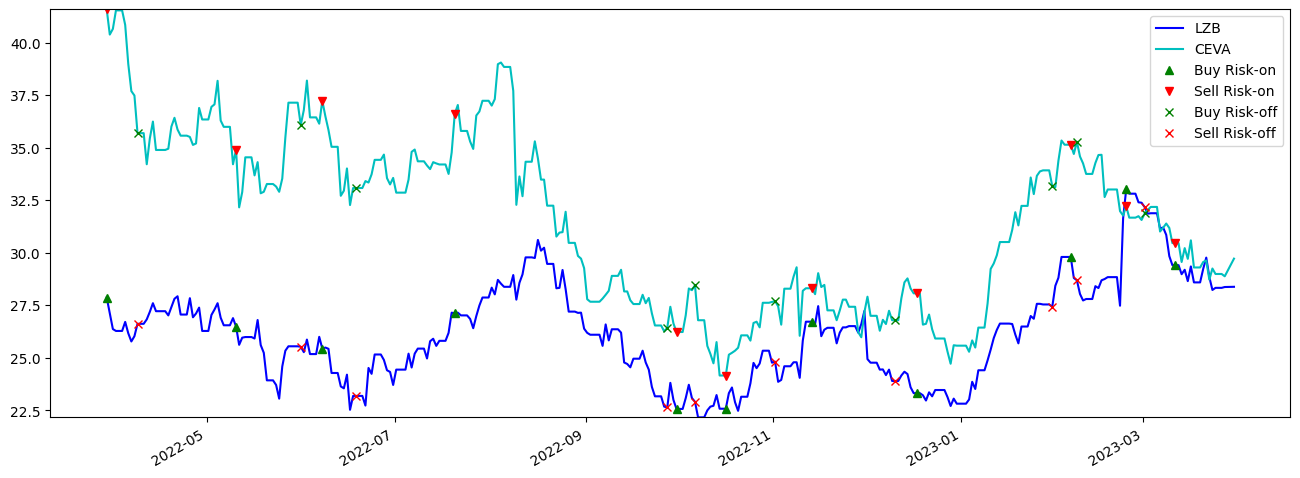

Total reward for this pair: 4.315796574067419
Total return for this pair: 5.1573260102431675


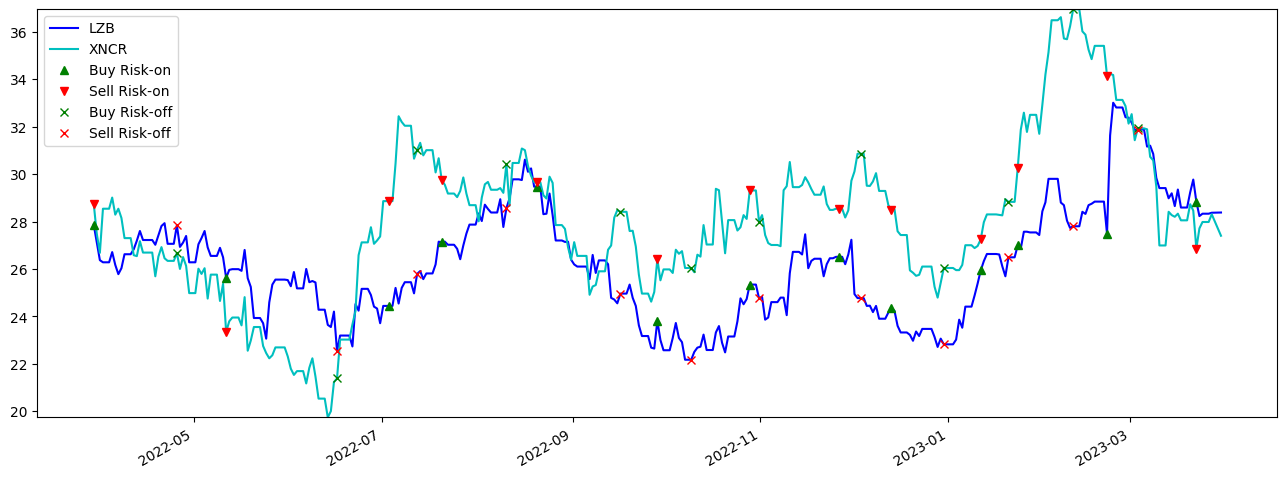

Total reward for this pair: -6.354790213772893
Total return for this pair: -6.10411940612848


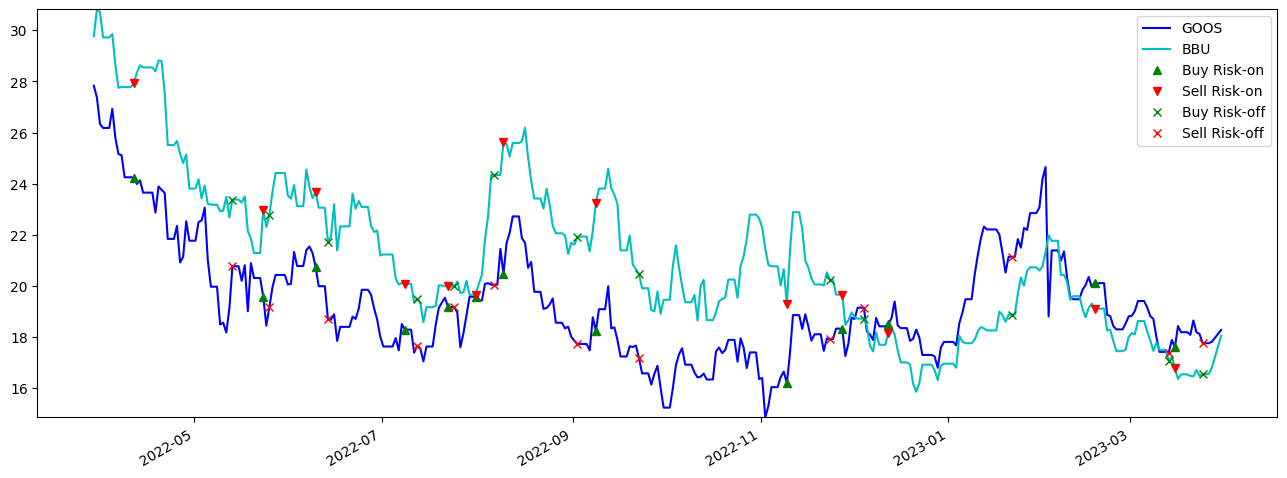

Total reward for this pair: -15.06289855502557
Total return for this pair: -14.743348653780673


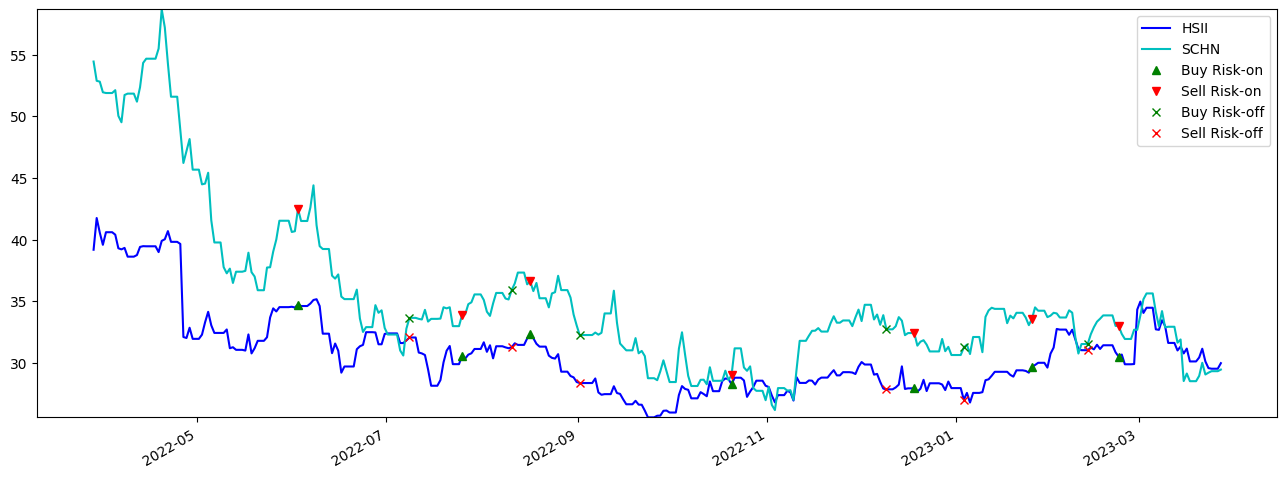

Total reward for this pair: -12.690555494233791
Total return for this pair: -12.688055494233794
Average overall rewards: 7.081224205254548
Average overall returns: 7.673444261436282


In [67]:
#plot entries/exits on val data
#fill in latest/best model
policy_net.load_state_dict(torch.load('./models/model (97).pth'))
target_net.load_state_dict(policy_net.state_dict())
policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
target_net.eval()

plot.plotEntryExits(policy_net, target_net, valenvs, device)

In [81]:
for k in val_return_dict.keys():
    if len(val_return_dict[k]) != 26742:
        print(k, val_return_dict[k])

243 []


In [74]:
plot.plot_episodes(val_return_dict)

TypeError: plot_episodes() got an unexpected keyword argument 'orient'

**Hyperparameters to tune**
1. Larger memory: 64000 - no visible improvement
2. lr: 1e-2 (R&R = 0, not sensitve at all), 1e-6 (show improving trend but R&R still negative)
3. activation function at output layer: Softmax can get to +ve return but reward still -ve; Sigmoid: +ve R&R! Record high scores!
4. different loss function: MSELoss terrible; L1Loss not impressive; BCELoss record scores! but seems unstable
5. GAMMA, TARGET_UPDATE
6. [more layers]
7. [increase batch size]

In [72]:
plot.plot_n_episodes(val_return_dict, 0, 100)

ValueError: All arrays must be of the same length

# APPLYING BEST MODEL ON UNSEEN DATA #

In [106]:
#revisit how many stocks in each cluster
for i in good_clusters_dict.keys():
    print(f'cluster {i}: {len(dailyDF[good_clusters_dict[i]].columns)} stocks')

cluster 0: 306 stocks
cluster 1: 14 stocks
cluster 3: 24 stocks
cluster 5: 74 stocks
cluster 6: 70 stocks
cluster 8: 403 stocks
cluster 9: 198 stocks


In [86]:
#function to get cluster performance in the testenv of an unseen cluster
def get_cluster_performance(policy_net, target_net, testenvs):
    policy_net.eval()   #changes forward(); disables Dropout, BatchNorm, etc.
    target_net.eval()

    total_rewards = []
    total_returns = []
    with torch.no_grad():
        for testenv in testenvs:
            obs = testenv.reset()
            state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
            for t in count():   #keep looping until done -> break
                # Select and perform an action
                action = policy_net(state).max(1)[1].view(1, 1)
                obs, _reward, done, info, _return = testenv.step(Positions(action.item()))
                state = torch.tensor(np.array([obs]), dtype=torch.float, device=device)
                
                if done:
                    total_rewards.append(info['total_reward'])
                    total_returns.append(info['total_return'])
                    break

    cluster_rewards = np.mean(total_rewards)
    cluster_returns = np.mean(total_returns)

    return cluster_rewards, cluster_returns

In [87]:
#find overall performance on all good and unseen clusters
def unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    overall_rewards = []
    overall_returns = []

    for i in good_clusters_dict.keys():
        #choose cluster of a reasonable size as test cluster
        dailyDF_test = dailyDF[good_clusters_dict[i]]

        #no need to plot heatmap; just to get the testpairs, testpval, testdf,
        testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))
        print(f'Cluster {i} has {len(testpairs)} testpairs.')

        #create testenvs
        testenvs = []
        for testpair in testpairs:
            testdata = testdf[list(testpair)].dropna()
            if testdata.shape[0] > 250:
                #instantiate an env; automatatically run trade()
                testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

        #get cluster performance
        cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
        print(f'For cluster {i}, overall reward is {cluster_rewards}, overall return is {cluster_returns}')

        overall_rewards.append(cluster_rewards)
        overall_returns.append(cluster_returns)
    
    print(f'For all clusters, total reward is {np.sum(overall_rewards)}, total return is {np.sum(overall_returns)}.')
    print(f'Average reward is {np.mean(overall_rewards)}, average return is {np.mean(overall_returns)}.')
        

In [88]:
#Average out all unseen clusters n times
def avg_n_performance(n, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net):
    avg_n_rewards = []
    avg_n_returns = []

    for e in range(n):

        ep_rewards = []
        ep_returns = []
        
        #loop through each good cluster
        for i in good_clusters_dict.keys():
            dailyDF_test = dailyDF[good_clusters_dict[i]]

            #no need to plot heatmap; just to get the testpairs, testpval, testdf,
            testpairs, _testpval, testdf = pipeline.find_pairs_pv_df(dailyDF_test.loc[train_enddate:].dropna(axis=1, how='all'))

            #create testenvs
            testenvs = []
            for testpair in testpairs:
                testdata = testdf[list(testpair)].dropna()
                if testdata.shape[0] > 250:
                    #instantiate an env; automatatically run trade()
                    testenvs.append(StockTradingEnvironment(testdata.copy(), window_size, transaction_cost))

            #get cluster performance
            cluster_rewards, cluster_returns = get_cluster_performance(policy_net, target_net, testenvs)
            
            ep_rewards.append(cluster_rewards)
            ep_returns.append(cluster_returns)
        
        avg_n_rewards.append(np.mean(ep_rewards))
        avg_n_returns.append(np.mean(ep_returns))
    
    #Plot all cumulative sums
    sns.lineplot(data=avg_n_rewards, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average rewards across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average rewards')
    plt.show()

    sns.lineplot(data=avg_n_returns, legend=False, dashes=False)#, palette=['pink'], dashes=False, legend=False)
    # Set the plot title and axis labels
    plt.suptitle('Trendline showing average returns across all clusters')
    plt.xlabel('Iterations')
    plt.ylabel('Average returns')
    plt.show()

    print(f'The average rewards and returns after {n} iterations are respectively {np.mean(avg_n_rewards)} and {np.mean(avg_n_returns)}.')
        

In [108]:
#One iteration of performance of all clusters
unseen_performance(good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)

Cluster 0 has 33 testpairs.
For cluster 0, overall reward is 0.7603540660689766, overall return is 1.0279883371077694
Cluster 1 has 9 testpairs.
For cluster 1, overall reward is 6.015116841084303, overall return is 6.243452928878077
Cluster 3 has 14 testpairs.
For cluster 3, overall reward is -1.1773950896059304, overall return is 0.7449184309974056
Cluster 5 has 31 testpairs.
For cluster 5, overall reward is -8.379583554612337, overall return is -7.316731397725887
Cluster 6 has 25 testpairs.
For cluster 6, overall reward is 8.009809411544905, overall return is 9.10328217219671
Cluster 8 has 70 testpairs.
For cluster 8, overall reward is -2.442546602563652, overall return is -2.3235929584322266
Cluster 9 has 26 testpairs.
For cluster 9, overall reward is 2.7396093876734233, overall return is 3.3928110742247783
For all clusters, total reward is 5.525364459589689, total return is 10.872128587246626.
Average reward is 0.7893377799413841, average return is 1.553161226749518.


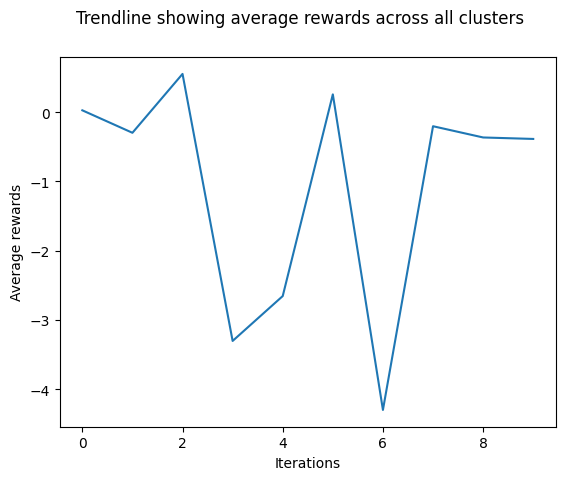

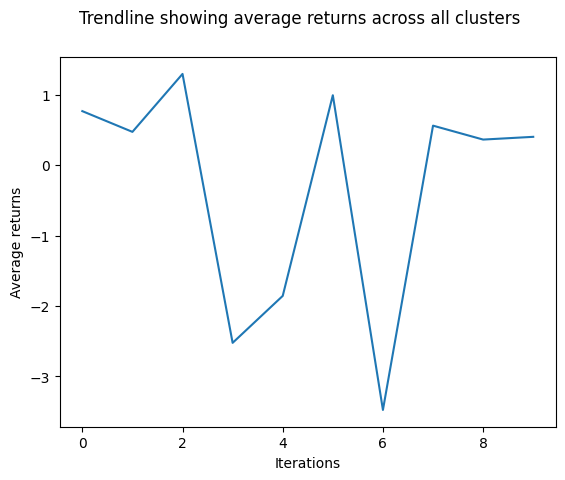

The average rewards and returns after 10 iterations are respectively -1.0671208920043291 and -0.30079491007372583.


In [109]:
#average out the performances of all clusters over total_iter times
total_iter = 10
avg_n_performance(total_iter, good_clusters_dict, dailyDF, train_enddate, policy_net, target_net)